### Data source: https://www.bracs.icar.cnr.it/

### Import packages

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,  UpSampling2D
from tensorflow.keras.layers import ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
from tensorflow.keras.layers import Conv2D, Input, Flatten, Add, Dropout, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.preprocessing import LabelBinarizer

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import seaborn as sns

2023-01-09 22:55:05.081738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

### Locate annotations

In [3]:
parent_folder = '/local_storage/High_Risk_Breast_Cancer_2022/bracs_icar/'

### Load data

In [6]:
%%time
data = np.load( parent_folder+'bracs_level4_regions_224_data.npy' )
label = np.load( parent_folder+'bracs_level4_regions_224_label.npy')
data.shape, label.shape

CPU times: user 1.58 ms, sys: 1.53 s, total: 1.53 s
Wall time: 1.53 s


((7763, 224, 224, 3), (7763,))

### Preprocess label

In [7]:
Counter(label)

Counter({'PATHOLOGICAL-BENIGN': 1733,
         'UDH': 759,
         'INVASIVE-CARCINOMA': 1900,
         'NORMAL': 863,
         'ADH': 598,
         'FEA': 575,
         'DCIS': 1335})

In [8]:
#Binary encode
lb = LabelBinarizer()
lb.fit(label)
label_oh = lb.transform(label)

In [9]:
label_oh.shape

(7763, 7)

In [10]:
lb.classes_

array(['ADH', 'DCIS', 'FEA', 'INVASIVE-CARCINOMA', 'NORMAL',
       'PATHOLOGICAL-BENIGN', 'UDH'], dtype='<U19')

In [11]:
label_oh[:10]

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0]])

### Define model

In [12]:
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
#backbone = tf.keras.applications.ResNet50( include_top=True, weights='imagenet', 
#                                           pooling='max', classifier_activation=None, classes=1)
backbone.trainable = True

def get_model():
    inp = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inp)
    x = backbone(x)
    x = tf.keras.layers.Flatten()(x)
    fc = tf.keras.layers.Dense(128, activation='relu')(x)
    fc = tf.keras.layers.BatchNormalization()(fc)
    #fc = tf.keras.layers.Dropout(0.25)(fc)
    #fc = tf.keras.layers.Dense(128, activation='relu')(fc)
    #fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.25)(fc)
    out = tf.keras.layers.Dense(7, activation='softmax')(fc) # was SIGMOID first
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    
    return model

model = get_model()

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                             

In [57]:
weights_folder = './weights_resnet50_bracs_softmax/'
weights_folder

'./weights_resnet50_bracs_softmax/'

In [58]:
os.makedirs( weights_folder, exist_ok=True )

### Fit model

### Create balanced data loader -> balanced folds with subset ?

In [59]:
def create_balanced_biopsy_subset(labels, minority_class_ratio=0.2, rnd_seed=38):
    # set random seed as given
    np.random.seed(rnd_seed)
    
    # collect selected biopsies that will be in the balanced subset
    test_local_idx = []
    
    # get current class occurences for biopsy
    class_occurence = np.array(list(dict( Counter(labels) ).values()))[ np.argsort(list(dict( Counter(labels) ).keys()))]
    #print(class_occurence)
    
    # calc class weights
    class_weights = ( class_occurence / class_occurence.sum() ).astype(np.float32)
    class_weights_dict = dict( zip( np.arange(class_weights.shape[0]), class_weights ))
    #print(class_weights_dict)
    
    # how many of biopsies to include in the balanced subset
    nr_class_test = int(labels.shape[0]*np.min(class_weights)*minority_class_ratio)

    # collect biopsy indices for the balanced subset
    for s in np.unique(labels): #loop over labelss
        s_idx = np.arange(labels.shape[0])[labels == s]
        rnd_idx = np.random.permutation(s_idx.shape[0])
        test_local_idx.append(s_idx[rnd_idx[:nr_class_test]])

    # aggregate all the balanced subset's indices
    test_idx = np.concatenate(test_local_idx)
    
    # other indices not in balanced set will be the rest
    train_idx = np.arange(labels.shape[0])[~np.in1d(np.arange(labels.shape[0]), test_local_idx)]
    
    return train_idx, test_idx#, label_remaining[]

In [60]:
remaining_idx, val_idx = create_balanced_biopsy_subset(label)

In [61]:
X_val = data[val_idx]
y_val = label[val_idx]
y_val = lb.transform(y_val)
X_remaining = data[remaining_idx]
y_remaining = label[remaining_idx]
X_val.shape, y_val.shape, X_remaining.shape, y_remaining.shape

((805, 224, 224, 3), (805, 7), (6958, 224, 224, 3), (6958,))

In [62]:
def give_back_balanced_training_fold( X_current, y_current,
                                      minority_class_ratio=0.5, rnd_seed=12 ):
    
    _, test_idx, = create_balanced_biopsy_subset(y_current,
                                                 minority_class_ratio,
                                                 rnd_seed)
    X_train_balanced = X_current[test_idx]
    y_train_balanced = y_current[test_idx]
    y_train_balanced_oh = lb.transform(y_train_balanced)
    #print( X_train_balanced.shape, y_train_balanced_oh.shape )
    
    return X_train_balanced, y_train_balanced_oh

In [63]:
X_train, y_train = give_back_balanced_training_fold(X_remaining, y_remaining, rnd_seed=15)
X_train.shape, y_train.shape

((1610, 224, 224, 3), (1610, 7))

### Train ResNet50 with balanced dataset

In [80]:
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
#backbone = tf.keras.applications.ResNet50( include_top=True, weights='imagenet', 
#                                           pooling='max', classifier_activation=None, classes=1)
backbone.trainable = True

def get_model():
    inp = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inp)
    x = backbone(x)
    x = tf.keras.layers.Flatten()(x)
    fc = tf.keras.layers.Dense(128, activation='relu')(x)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.5)(fc)
    fc = tf.keras.layers.Dense(128, activation='relu')(fc)
    fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dropout(0.25)(fc)
    out = tf.keras.layers.Dense(7, activation='softmax')(fc) # was SIGMOID first
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    
    return model

model = get_model()


model.compile( loss="categorical_crossentropy", 
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True), 
               metrics=['accuracy'])    
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 128)               2622

In [81]:
weights_folder

'./weights_resnet50_bracs_softmax/'

In [82]:
loss_history = []

X_train_balanced, y_train_balanced = give_back_balanced_training_fold( X_remaining, y_remaining, 
                                                                       rnd_seed=0, minority_class_ratio=0.25 )
print(X_train_balanced.shape, y_train_balanced.shape)

weights_name = weights_folder + 'resnet50_epoch_0.hdf5'
mc = tf.keras.callbacks.ModelCheckpoint( weights_name,
                          monitor='val_loss', save_best_only=False, mode='min' )

history = model.fit( X_train_balanced,
                     y_train_balanced,
                     validation_data=( X_val, y_val ), 
                     batch_size=32,
                     callbacks=[mc],
                     verbose=1 )
loss_history.append( [ history.history['loss'], history.history['val_loss'] ] )


for e in range(1,50): # epochs
    print(e)
    X_train_balanced, y_train_balanced = give_back_balanced_training_fold( X_remaining, y_remaining, 
                                                                           rnd_seed=int(e*1.5+3*e),
                                                                           minority_class_ratio=0.25 )
    
    model.load_weights(weights_name)
    weights_name = weights_folder + 'resnet50_epoch_' + str(e) + '.hdf5'
    mc = tf.keras.callbacks.ModelCheckpoint( weights_name, 
                          monitor='val_loss', save_best_only=False, mode='min' )

    history = model.fit( X_train_balanced,
                     y_train_balanced,
                     validation_data=( X_val, y_val ), 
                     batch_size=32,
                     callbacks=[mc],
                     verbose=1 )
    loss_history.append( [ history.history['loss'], history.history['val_loss'] ] )

(805, 224, 224, 3) (805, 7)
26/26 [==============================] - 32s 264ms/step - loss: 2.5995 - accuracy: 0.1826 - val_loss: 2.0239 - val_accuracy: 0.2174
1
26/26 [==============================] - 6s 232ms/step - loss: 2.1402 - accuracy: 0.2845 - val_loss: 1.8892 - val_accuracy: 0.2696
2
26/26 [==============================] - 6s 230ms/step - loss: 1.9078 - accuracy: 0.3391 - val_loss: 1.8515 - val_accuracy: 0.3205
3
26/26 [==============================] - 6s 231ms/step - loss: 1.7577 - accuracy: 0.3876 - val_loss: 1.7018 - val_accuracy: 0.3888
4
26/26 [==============================] - 6s 233ms/step - loss: 1.6859 - accuracy: 0.4323 - val_loss: 1.6194 - val_accuracy: 0.4261
5
26/26 [==============================] - 6s 231ms/step - loss: 1.6232 - accuracy: 0.4385 - val_loss: 1.5206 - val_accuracy: 0.4646
6
26/26 [==============================] - 6s 230ms/step - loss: 1.5605 - accuracy: 0.4671 - val_loss: 1.5542 - val_accuracy: 0.4857
7
26/26 [==============================] -

In [83]:
loss_history = np.concatenate( loss_history, axis=1 ).T

In [84]:
np.argmin(loss_history[:,1]), loss_history[ np.argmin(loss_history[:,1]) ]

(24, array([1.14168489, 1.28965354]))

In [85]:
filt_high = loss_history[:,1] > 10
loss_history[filt_high,1] = np.nan

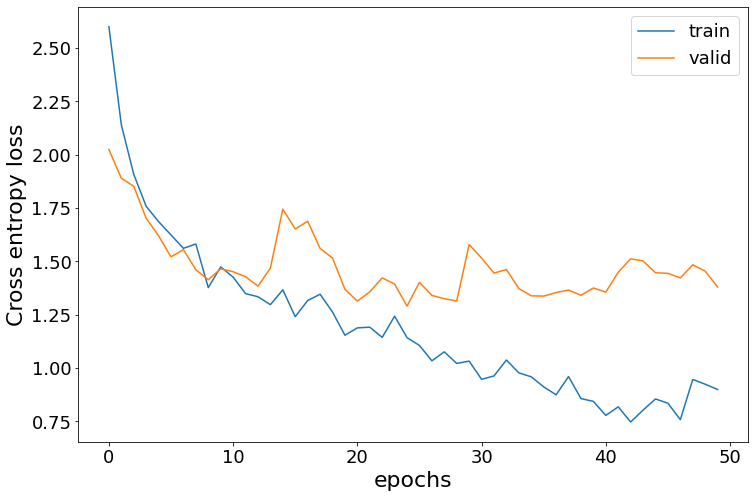

In [86]:
plt.figure(figsize=(12,8))
plt.plot( np.arange(loss_history.shape[0]), loss_history[:,0], label='train' )
plt.plot( np.arange(loss_history.shape[0]), loss_history[:,1], label='valid' )
plt.legend(fontsize=18)
plt.xlabel('epochs', fontsize=22)
plt.ylabel('Cross entropy loss', fontsize=22)
plt.tick_params(labelsize=18)
#plt.yscale('log')

### Load back best weighs

In [87]:
model.load_weights(weights_folder+'resnet50_epoch_24.hdf5')

### Eval based on each label, confusion matrix, etc..

In [88]:
y_val_predict = model.predict(X_val)
y_val_predict.shape

26/26 [==============================] - 2s 41ms/step


(805, 7)

In [89]:
y_val_predict_label = np.argmax( y_val_predict, axis=1 )
y_val_label = np.argmax( y_val, axis=1 )
y_val_predict_label.shape, y_val_label.shape

((805,), (805,))

In [90]:
score = accuracy_score(y_val_label, y_val_predict_label)
print("accuracy:   %0.3f" % score)

accuracy:   0.535


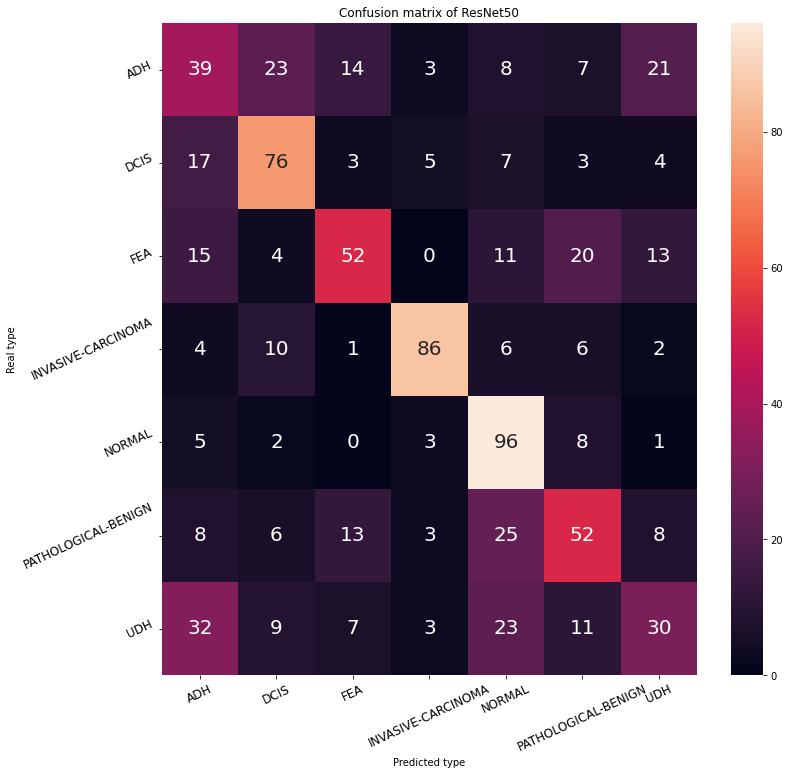

In [91]:
# calculating the confusion matrix
confusion_matrix = pd.crosstab( y_val_label, y_val_predict_label,
                                rownames=['Real type'], colnames=['Predicted type'] )
#print( confusion_matrix )

# visualizng it on a heatmap
plt.figure(figsize=(12,12))
plt.title( 'Confusion matrix of ResNet50')
sns.heatmap(confusion_matrix, annot=True, xticklabels=np.array(lb.classes_), 
            yticklabels=np.array(lb.classes_), annot_kws={"size": 20} )
plt.tick_params(labelsize=12, rotation=25)
plt.xlabel('Predicted type')
plt.show()

In [78]:
y_val_predict[0]

array([0.04349728, 0.02826766, 0.89090574, 0.0042148 , 0.01868867,
       0.00794708, 0.00647878], dtype=float32)

In [ ]:
lb

In [79]:
np.argmax( y_val_predict, axis=1 )

array([2, 1, 2, 5, 1, 1, 1, 6, 1, 5, 6, 3, 6, 5, 4, 1, 0, 0, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 6, 2, 6, 1, 1, 3, 0, 6, 4, 4, 4, 1, 2, 4, 0, 5, 1,
       1, 2, 6, 6, 2, 1, 1, 1, 1, 0, 6, 1, 4, 1, 2, 6, 6, 1, 1, 2, 2, 6,
       0, 1, 5, 1, 6, 2, 6, 0, 0, 2, 1, 6, 5, 2, 2, 0, 1, 1, 1, 6, 3, 0,
       1, 2, 2, 0, 1, 5, 2, 1, 0, 2, 3, 2, 6, 3, 1, 6, 2, 2, 2, 1, 6, 6,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 0, 2, 0, 1, 4, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 5, 1, 6, 1, 5, 1, 1, 1, 1, 2, 5, 3, 1, 2, 6, 6, 1,
       3, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1,
       3, 1, 1, 3, 1, 1, 4, 2, 1, 1, 2, 2, 2, 5, 2, 6, 1, 2, 1, 4, 5, 2,
       2, 2, 3, 1, 2, 2, 6, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 6, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 3,
       2, 2, 3, 2, 2, 2, 0, 2, 4, 2, 2, 2, 4, 2, 2,